In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import ImageDataGenerator 


Using TensorFlow backend.


In [2]:
import json
def load_and_format(in_path):
    out_df = pd.read_json(in_path)  
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2'],np.add(c_row['band_1'],c_row['band_2'])/2], -1).reshape((75,75,3))],1)
    out_images = np.stack(out_images).squeeze()
    #out_images[:,:,:,0] = (out_images[:,:,:,0]-out_images[:,:,:,0].min())/(out_images[:,:,:,0].max()-out_images[:,:,:,0].min())
    #out_images[:,:,:,1] = (out_images[:,:,:,1]-out_images[:,:,:,1].min())/(out_images[:,:,:,1].max()-out_images[:,:,:,1].min())
    #out_images[:,:,:,2] = (out_images[:,:,:,2]-out_images[:,:,:,2].min())/(out_images[:,:,:,2].max()-out_images[:,:,:,2].min())
    return out_df, out_images
train_df, train_images = load_and_format('data/train.json')
print('training', train_df.shape, 'loaded', train_images.shape)

training (1604, 5) loaded (1604, 75, 75, 3)


In [3]:
from keras.utils.np_utils import to_categorical

X_img = train_images
X_ang = train_df['inc_angle'].replace('na',0) / 50
y = to_categorical(train_df['is_iceberg'])
print('Train', X_img.shape, y.shape)

Train (1604, 75, 75, 3) (1604, 2)


In [4]:
def plot_list(arr):
    fig = plt.figure()
    gs1 = gridspec.GridSpec(len(arr),1)
    for idx,ar in zip(range(len(arr)),arr):        
        ax = fig.add_subplot(gs1[idx])
        ax.plot(ar)
        
    gs1.tight_layout(fig)
    
import tensorflow as tf
def create_placeholders():
     ###place holders 
    global input_,input_post,label,keep_prob,is_train
    input_ = tf.placeholder(tf.float32, (None, 75, 75,3), name = 'features')
    input_post = tf.placeholder(tf.float32, (None,1), name = 'features2')
    label = tf.placeholder(tf.int32, (None, 2), name = 'labels')
    keep_prob = tf.placeholder(tf.float32)
    is_train = tf.placeholder(tf.bool, name='is_train')
tf.reset_default_graph()

In [5]:
def lrelu(x, n, leak=0.2): 
    return tf.maximum(x, leak * x, name=n) 
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05), name="weight")
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]), name ="bias")
def new_conv_layer(input, num_input_channels, filter_size, num_filters, num, is_train, use_pooling=True, use_bn=True
                  ):  
    
    conv = tf.layers.conv2d(input, num_filters, kernel_size=[filter_size, filter_size], strides=[1, 1], padding="SAME",
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),name='conv'+str(num))
    
    if use_bn:
        conv = tf.contrib.layers.batch_norm(conv, is_training = is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope = 'bn'+str(num))
    
    if use_pooling:
        conv = tf.nn.max_pool(value=conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer = lrelu(conv, n='act'+str(num))
    return layer

## Best Hyperparameters
filter_size = [3,3,3,3,3,3]          
num_filters = [3,8,16,36,36,64,64,128]     
drop_out = [1,.75,.75,.85,.75,.65,.55]  [1,.75,.85,.90,.85,.65,.55]  
pooling = [False,True,True,True,True,True,True]
     

In [6]:
num_channels = 3
## Hyperparameters
filter_size = [3,3,3,3,3,3]          
num_filters = [3,8,16,26,36,64,64,128]     
drop_out = [1,.5,.5,.5,.5,.65,.55]
pooling = [False,True,True,True,True,True,True]
bn = [True,True,True,True,True,False,True]

In [7]:
def CNN(conv,filter_size,num_filters,drop_out):
   
    ####33##########
    #batch_norm = tf.layers.batch_normalization(x, training=is_train)
    for n in range(len(filter_size)):
        conv = new_conv_layer(input=conv,
                           num_input_channels=num_filters[n],
                           filter_size=filter_size[n],
                           num_filters=num_filters[n+1],
                           num = n, is_train = is_train,
                           use_pooling=pooling[n],
                           use_bn= bn[n])
        conv = tf.nn.dropout(conv, drop_out[n] + (1-drop_out[n])*keep_prob)
        print(conv.shape)

    _, height, width, depth = conv.shape
    
    tensor_size = int(height * width * depth +1) 
    flatten_layer = tf.reshape(conv, [-1, tensor_size-1])
    
    fc1_hidden_unit = int(tensor_size/1.5)
    print(tensor_size)
    print(fc1_hidden_unit)
    drop_fc1 = tf.nn.dropout(flatten_layer, 0.58 + keep_prob*0.42)
    drop_feat = tf.concat( [flatten_layer, input_post ], 1 )
    W_fc1 = new_weights([tensor_size, fc1_hidden_unit])
    b_fc1 = new_biases(fc1_hidden_unit)
    
    fc1 = lrelu(tf.add(tf.matmul(drop_feat, W_fc1), b_fc1),"fc1")
    drop_fc2 = tf.nn.dropout(fc1, 0.75 + 0.25*keep_prob)   #85
    
    n_class = 2
    W_fc2 = new_weights([fc1_hidden_unit, n_class])
    b_fc2 = new_biases(n_class)
                     
    logits = tf.add(tf.matmul(drop_fc2, W_fc2), b_fc2)
    
    return logits

In [8]:
tf.reset_default_graph()
create_placeholders()
logits = CNN(input_,filter_size,num_filters,drop_out)
logits_soft =tf.nn.softmax(logits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = label, logits = logits)
#error = tf.square(label-logits)/2
var_s = tf.trainable_variables()
loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in var_s if 'bias' not in v.name])*0.0001
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer().minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1)), tf.float32))

(?, 75, 75, 8)
(?, 38, 38, 16)
(?, 19, 19, 26)
(?, 10, 10, 36)
(?, 5, 5, 64)
(?, 3, 3, 64)
577
384


In [9]:

sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
best_accuracy,min_loss = 0,10
acc_rec, loss_rec, loss_train = [], [], []

from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator(
                            width_shift_range=0,
                            height_shift_range=0,
                            zoom_range=0.22,
                            rotation_range = 20,
                            horizontal_flip=False,
                            vertical_flip=False)
                            #fill_mode='nearest')
datagen.fit(X_img)

from sklearn.model_selection import KFold
kf = KFold(n_splits=5)


In [14]:
n_epoch = 250
batch_size =64
# early stopping
patience =10
min_delta = 0.01
early_stop = False

n_folds = kf.get_n_splits(X_img)

for e in range(int(n_epoch/n_folds)):
    if early_stop == False:
        
        for train_index, test_index in kf.split(X_img):
            n_batch = 0

            y_datagen = [[y[x,0],y[x,1],X_ang.values[x]] for x in train_index]
            i = 0
            for x_batch, y_batch in datagen.flow(X_img[train_index], y_datagen, batch_size=batch_size):
                
                feed_dict = {input_: x_batch,label: y_batch[:,:2],
                                 input_post:y_batch[:,2:],keep_prob:0,is_train:True}
                _, loss_ = sess.run([optimizer, loss], feed_dict )
                train_acc = accuracy.eval(feed_dict = feed_dict,session=sess)

                if int(len(train_index)/batch_size/4)*2 / (n_batch+1)  == 1:
                    val_feed_dict = {input_: X_img[test_index],label:y[test_index], 
                                     input_post:X_ang[test_index].values.reshape([-1,1]),
                                     keep_prob:1,is_train:True }

                    val_loss = sess.run(loss, feed_dict = val_feed_dict)
                    val_acc = accuracy.eval(feed_dict = val_feed_dict,session=sess)
                    acc_rec.append(val_acc)
                    loss_rec.append(val_loss)
                    loss_train.append(loss_)
                    if val_acc > best_accuracy:
                        best_accuracy = val_acc
                        saver.save(sess, 'models/my_model_acc')
                        imp_str_acc = '*'*4
                        patience_cnt = 0
                    else:
                        imp_str_acc = ''
                        patience_cnt +=1

                    if val_loss<min_loss:
                        min_loss = val_loss
                        saver.save(sess, 'models/my_model_loss')
                        imp_str_loss = '*'*4
                    else:
                        imp_str_loss = ''

                    msg = "Epoch {}   Train Acc: {:.2}  Valditaion Loss: {:.3}{}, Validation Accuracy: {:.3}{}"
                    print(msg.format(e, train_acc, val_loss,imp_str_loss, val_acc, imp_str_acc))
                    if patience_cnt > patience and False:
                        print("early stopping...")
                        early_stop = True
                        break
                    
                n_batch +=1
                
                if n_batch*batch_size>len(train_index):
                    break



Epoch 0   Train Acc: 0.88  Valditaion Loss: 0.226, Validation Accuracy: 0.913
Epoch 0   Train Acc: 0.83  Valditaion Loss: 0.172, Validation Accuracy: 0.922
Epoch 0   Train Acc: 0.8  Valditaion Loss: 0.226, Validation Accuracy: 0.891
Epoch 0   Train Acc: 0.88  Valditaion Loss: 0.204, Validation Accuracy: 0.928
Epoch 0   Train Acc: 0.83  Valditaion Loss: 0.184, Validation Accuracy: 0.934
Epoch 1   Train Acc: 0.88  Valditaion Loss: 0.225, Validation Accuracy: 0.913
Epoch 1   Train Acc: 0.92  Valditaion Loss: 0.205, Validation Accuracy: 0.916
Epoch 1   Train Acc: 0.88  Valditaion Loss: 0.227, Validation Accuracy: 0.9
Epoch 1   Train Acc: 0.94  Valditaion Loss: 0.176, Validation Accuracy: 0.931
Epoch 1   Train Acc: 0.83  Valditaion Loss: 0.135, Validation Accuracy: 0.953
Epoch 2   Train Acc: 0.86  Valditaion Loss: 0.212, Validation Accuracy: 0.913
Epoch 2   Train Acc: 0.78  Valditaion Loss: 0.183, Validation Accuracy: 0.944
Epoch 2   Train Acc: 0.91  Valditaion Loss: 0.232, Validation Accur

Epoch 21   Train Acc: 0.91  Valditaion Loss: 0.185, Validation Accuracy: 0.928
Epoch 21   Train Acc: 0.92  Valditaion Loss: 0.14, Validation Accuracy: 0.947
Epoch 21   Train Acc: 0.92  Valditaion Loss: 0.191, Validation Accuracy: 0.913
Epoch 21   Train Acc: 0.89  Valditaion Loss: 0.155, Validation Accuracy: 0.935
Epoch 21   Train Acc: 0.91  Valditaion Loss: 0.123, Validation Accuracy: 0.95
Epoch 22   Train Acc: 0.83  Valditaion Loss: 0.177, Validation Accuracy: 0.935
Epoch 22   Train Acc: 0.89  Valditaion Loss: 0.147, Validation Accuracy: 0.944
Epoch 22   Train Acc: 0.92  Valditaion Loss: 0.193, Validation Accuracy: 0.922
Epoch 22   Train Acc: 0.86  Valditaion Loss: 0.179, Validation Accuracy: 0.928
Epoch 22   Train Acc: 0.91  Valditaion Loss: 0.116****, Validation Accuracy: 0.953
Epoch 23   Train Acc: 0.86  Valditaion Loss: 0.177, Validation Accuracy: 0.928
Epoch 23   Train Acc: 0.89  Valditaion Loss: 0.132, Validation Accuracy: 0.953
Epoch 23   Train Acc: 0.86  Valditaion Loss: 0.188

KeyboardInterrupt: 

best Acc: 0.972, Min loss: 0.0979


<IPython.core.display.Javascript object>


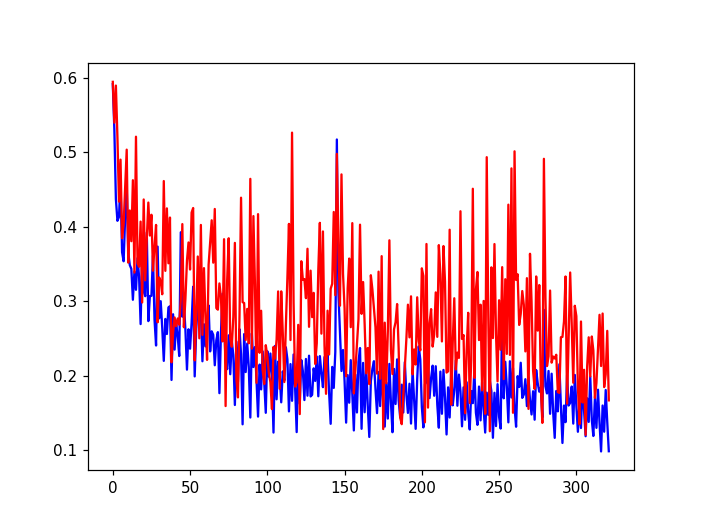

<IPython.core.display.Javascript object>


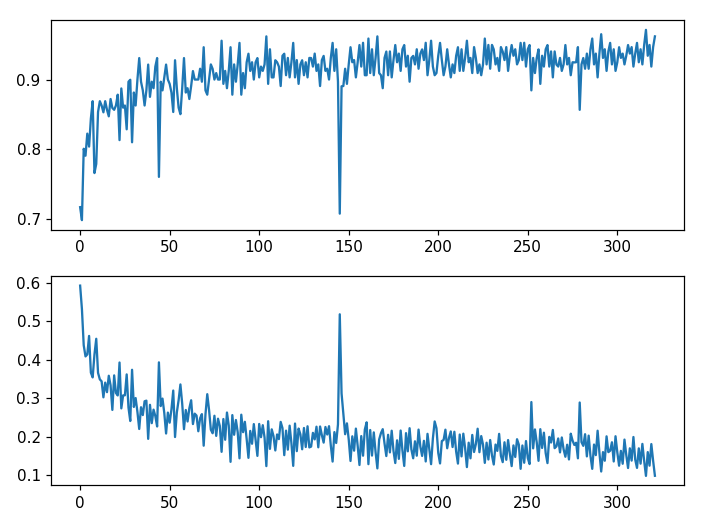

In [15]:
%matplotlib notebook
print('best Acc: {:.3}, Min loss: {:.3}'.format(best_accuracy,min_loss))
plt.plot(loss_rec[1:],'b')
plt.plot(loss_train[1:],'r')
plot_list([acc_rec[1:],loss_rec[1:]])

In [77]:
acc_rec_list = np.array(loss_rec)
acc_rec_list[acc_rec[:]==max(acc_rec)]

array([ 0.18947038,  0.19007033], dtype=float32)

In [15]:
np.floor(1.8)

1.0

In [18]:
def predict_batch(test_imgages,inc_ang,length = 1000):
    prev_index = 0
    for x in range(int(np.floor(len(inc_ang)/length))):
        index = (x+1) * length
        feed_dict_sub = {input_: test_imgages[prev_index:index], input_post:inc_ang[prev_index:index], keep_prob:1,is_train:False} 
        
        
        pred = sess.run(logits_soft,feed_dict=feed_dict_sub)
        if x == 0:
            return_sub = pred
        else:
            return_sub = np.concatenate((return_sub,pred))
        prev_index = index
    feed_dict_sub = {input_: test_imgages[prev_index:], input_post:inc_ang[prev_index:], keep_prob:1,is_train:False} 
    pred = sess.run(logits_soft,feed_dict=feed_dict_sub)
    return_sub = np.concatenate((return_sub,pred))
    return return_sub

In [19]:
test_df, test_imgages = load_and_format('data/test.json')
print('ok')

ok


In [20]:
inc_ang = test_df['inc_angle'].replace('na',0) / 50
inc_ang = inc_ang.as_matrix().reshape([-1,1])

In [21]:
saver.restore(sess,"models/my_model_loss")
sub_loss = predict_batch(test_imgages,inc_ang)
saver.restore(sess,"models/my_model_acc")
sub_acc = predict_batch(test_imgages,inc_ang)


INFO:tensorflow:Restoring parameters from models/my_model_loss
INFO:tensorflow:Restoring parameters from models/my_model_acc


In [22]:
sub_loss = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_loss]
sub_acc = [1-p[0] if np.argmax(p)==0 else p[1]  for p in sub_acc]
sub_data = (np.array(sub_loss) + np.array(sub_acc))/2

In [23]:
sub = pd.DataFrame()
sub['id'] = test_df['id']
sub['is_iceberg'] = sub_acc

In [24]:
sub.to_csv("sub/sub_loss{:.3}_acc{:.3}.csv".format(min_loss,best_accuracy), index = False)

In [25]:
saver.restore(sess,"models/my_model_loss")


INFO:tensorflow:Restoring parameters from models/my_model_loss
